In [1]:
import pandas as pd
import numpy as np
import math
from numpy import array
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
from Software import cbrFox

In [2]:
def split_sequences(sequences, n_steps):
    inputnn, target = list(), list()
    for i in range(len(sequences)):
        end_ix = i + n_steps
        if end_ix + 1 > len(sequences):
            break
        seq_x, seq_y = sequences[i:end_ix], sequences[end_ix, (1, 4, 7)]
        inputnn.append(seq_x)
        target.append(seq_y)
    return array(inputnn), array(target)

In [3]:
data = pd.read_csv("D:\drive\GitHub\Weather-Forecasting-CBR-fox\Jupyter\weatherdata.csv", parse_dates=True, index_col=1)


In [4]:
data

,DATE,TEMP_MAX,TEMP_MIN,TEMP_AVG,PRES_AVG,PRES_MAX,PRES_MIN,HUM_AVG,HUM_MAX,HUM_MIN
MONTH,,,,,,,,,,
JANUARY,2000-01-01,29.9,19.2,24.55,23.100000,25.300000,18.500000,80.000000,96.000000,55.000000
JANUARY,2000-01-02,31.6,21.0,26.30,24.900000,27.600000,23.200000,78.000000,93.000000,53.000000
JANUARY,2000-01-03,31.2,20.0,25.60,25.000000,29.300000,23.300000,83.000000,99.000000,54.000000
JANUARY,2000-01-04,30.8,18.8,24.80,24.500000,27.100000,22.800000,87.000000,99.000000,55.000000
JANUARY,2000-01-05,23.8,18.8,21.30,21.300000,23.200000,19.200000,87.000000,96.000000,72.000000
...,...,...,...,...,...,...,...,...,...,...
SEPTEMBER,2018-09-25,35.2,24.6,29.90,33.605244,39.293133,29.971286,85.807829,96.598891,66.220121
SEPTEMBER,2018-09-26,35.7,24.8,30.25,33.215072,38.461184,30.121252,84.474650,95.796130,65.107947
SEPTEMBER,2018-09-27,34.5,24.7,29.60,33.329421,39.033815,30.356106,87.932543,98.304236,71.282447


In [5]:
np.max(data.filter(['HUM_MAX']).values)

113.1932031

In [6]:
step_days = 14
dataset = data.filter(['HUM_MIN', 'HUM_AVG', 'HUM_MAX', 'PRES_MIN', 'PRES_AVG', 'PRES_MAX', 'TEMP_MIN',
                       'TEMP_AVG', 'TEMP_MAX']).values
dataset = np.array(dataset)
# dataset = MinMaxScaler().fit_transform(dataset)
global inputnn, target, input_train, input_test, target_test, target_train
inputnn, target = split_sequences(dataset, step_days)
input_train, input_test, target_train, target_test = train_test_split(inputnn, target, test_size=0.30,
                                                                      random_state=4, shuffle=False)

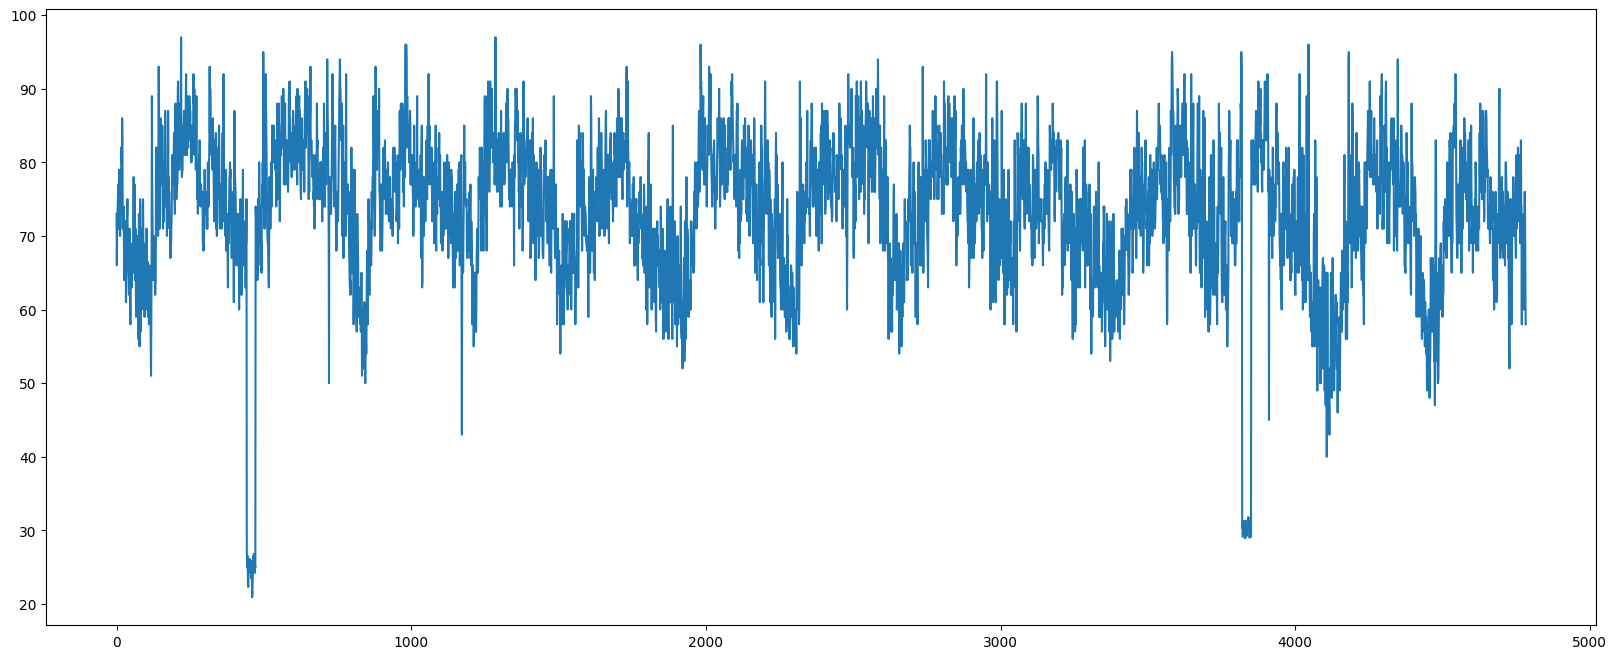

In [7]:
plt.figure(figsize=(20, 8))
plt.plot(target_train[:, 0])

In [8]:
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(step_days, input_train.shape[2])))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(3))
model.compile(optimizer='adam', loss='mse')
history = model.fit(input_train, target_train, validation_data=(input_test, target_test), batch_size=16, epochs=9)

Epoch 1/9
299/299 [==============================] - 11s 24ms/step - loss: 362.6791 - val_loss: 29.7292
Epoch 2/9
299/299 [==============================] - 6s 20ms/step - loss: 118.6006 - val_loss: 21.8626
Epoch 3/9
299/299 [==============================] - 7s 22ms/step - loss: 100.9497 - val_loss: 27.6780
Epoch 4/9
299/299 [==============================] - 7s 25ms/step - loss: 92.0869 - val_loss: 18.3341
Epoch 5/9
299/299 [==============================] - 6s 21ms/step - loss: 91.5162 - val_loss: 18.7053
Epoch 6/9
299/299 [==============================] - 6s 19ms/step - loss: 86.3583 - val_loss: 18.1731
Epoch 7/9
299/299 [==============================] - 6s 19ms/step - loss: 83.5785 - val_loss: 39.3592
Epoch 8/9
299/299 [==============================] - 5s 18ms/step - loss: 80.3401 - val_loss: 17.9839
Epoch 9/9
299/299 [==============================] - 5s 18ms/step - loss: 77.5671 - val_loss: 17.7453


### Realizando la predicción para todas las ventanas de entrenamiento

In [9]:
prediction_train = model.predict(input_train)

150/150 [==============================] - 2s 8ms/step


### Evaluando la red

In [10]:
RMSE = math.sqrt(np.square(np.subtract(prediction_train, target_train)).mean())
print("Root Mean Square Error Train:\n", RMSE)
prediction = model.predict(input_test)
RMSE = math.sqrt(np.square(np.subtract(prediction, target_test)).mean())
print("Root Mean Square Error Test:\n", RMSE)

Root Mean Square Error Train:
 4.452804870196451
65/65 [==============================] - 0s 7ms/step
Root Mean Square Error Test:
 4.212516690427462


### Se le aplica el formato para que la red pueda predecir UNA muestra

In [11]:
prediction = model.predict(inputnn[-1].reshape((1, 14, 9)))

1/1 [==============================] - 0s 31ms/step


## Sección de CBR-FOX

Las variables son las procesadas para la red neuronal. Se envían TODAS las ventanas generadas a excepción de la última, cual es la ventana a evaluar, la ventana del caso de estudio. También se envían los targets de TODAS las ventanas. En otro caso, solamente se debería mandar las ventas y targets que se utilizaron para entrenar la red

In [12]:
windows = inputnn[0:-1]
targetWindow = inputnn[-1]
num_cases = 5
target = target
smoothnessFactor = .04
inputNames = ['HUM_MIN', 'HUM_AVG', 'HUM_MAX', 'PRES_MIN', 'PRES_AVG', 'PRES_MAX', 'TEMP_MIN',
              'TEMP_AVG', 'TEMP_MAX']
outputNames = ['HUM_AVG', 'PRES_AVG', 'TEMP_AVG']
punishedSumFactor = .5

## Se crea una instancia de la clase

In [13]:
cbrFoxInstancia = cbrFox(windows=windows, targetWindow=targetWindow, target=target, prediction=prediction, num_cases=num_cases,
                         smoothnessFactor=smoothnessFactor, inputNames=inputNames, outputNames=outputNames,
                         punishedSumFactor=punishedSumFactor)

In [14]:
cbrFoxInstancia.explain()

Calculando correlación de Pearson


D:\programas\Python310\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
D:\programas\Python310\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Calculando distancia Euclidiana
Aplicando el algoritmo LOWESS
Extrayendo crestas y valles
Extrayendo segmentos cóncavos y convexos
Recuperando índices originales de las ventanas
Calculando MAE para cada ventana
Generando reporte de análisis


## Visualización de los resultados de explicación

### Visualización de la correlación de las ventanas

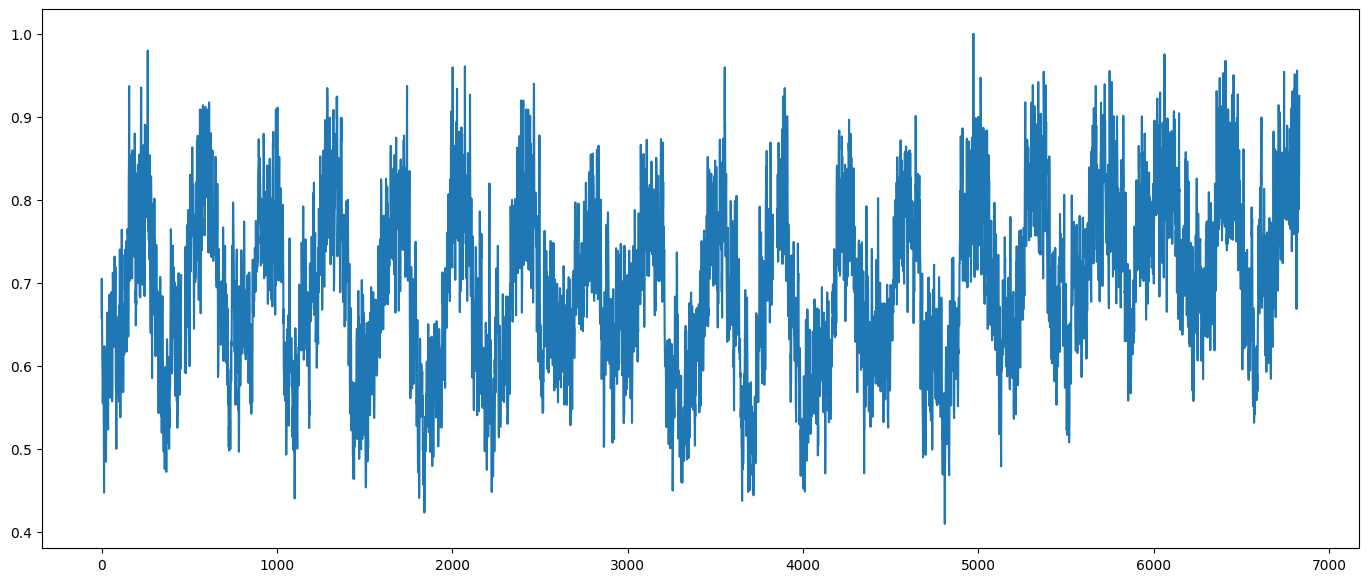

In [15]:
cbrFoxInstancia.visualizeCorrelationPerWindow()

### Visualización de las correlaciones con suavizado aplicado

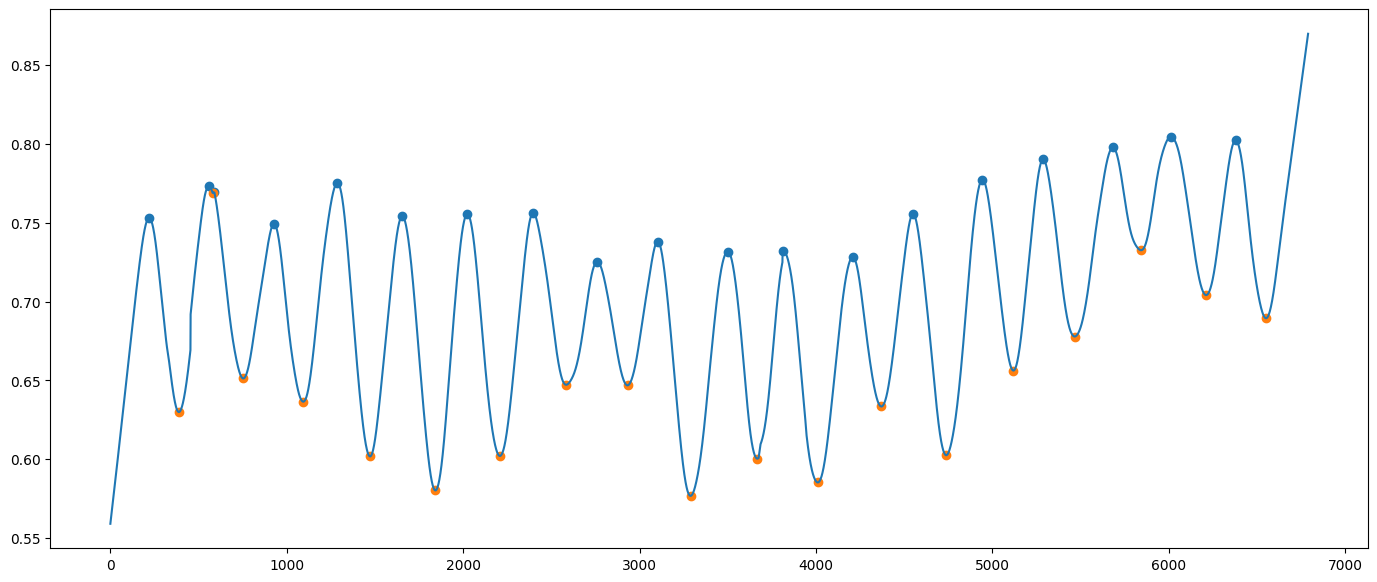

In [16]:
cbrFoxInstancia.visualizeSmoothedCorrelation()

### Visualización de las ventanas más parecidas a la ventana de estudio de acuerdo a cada componente

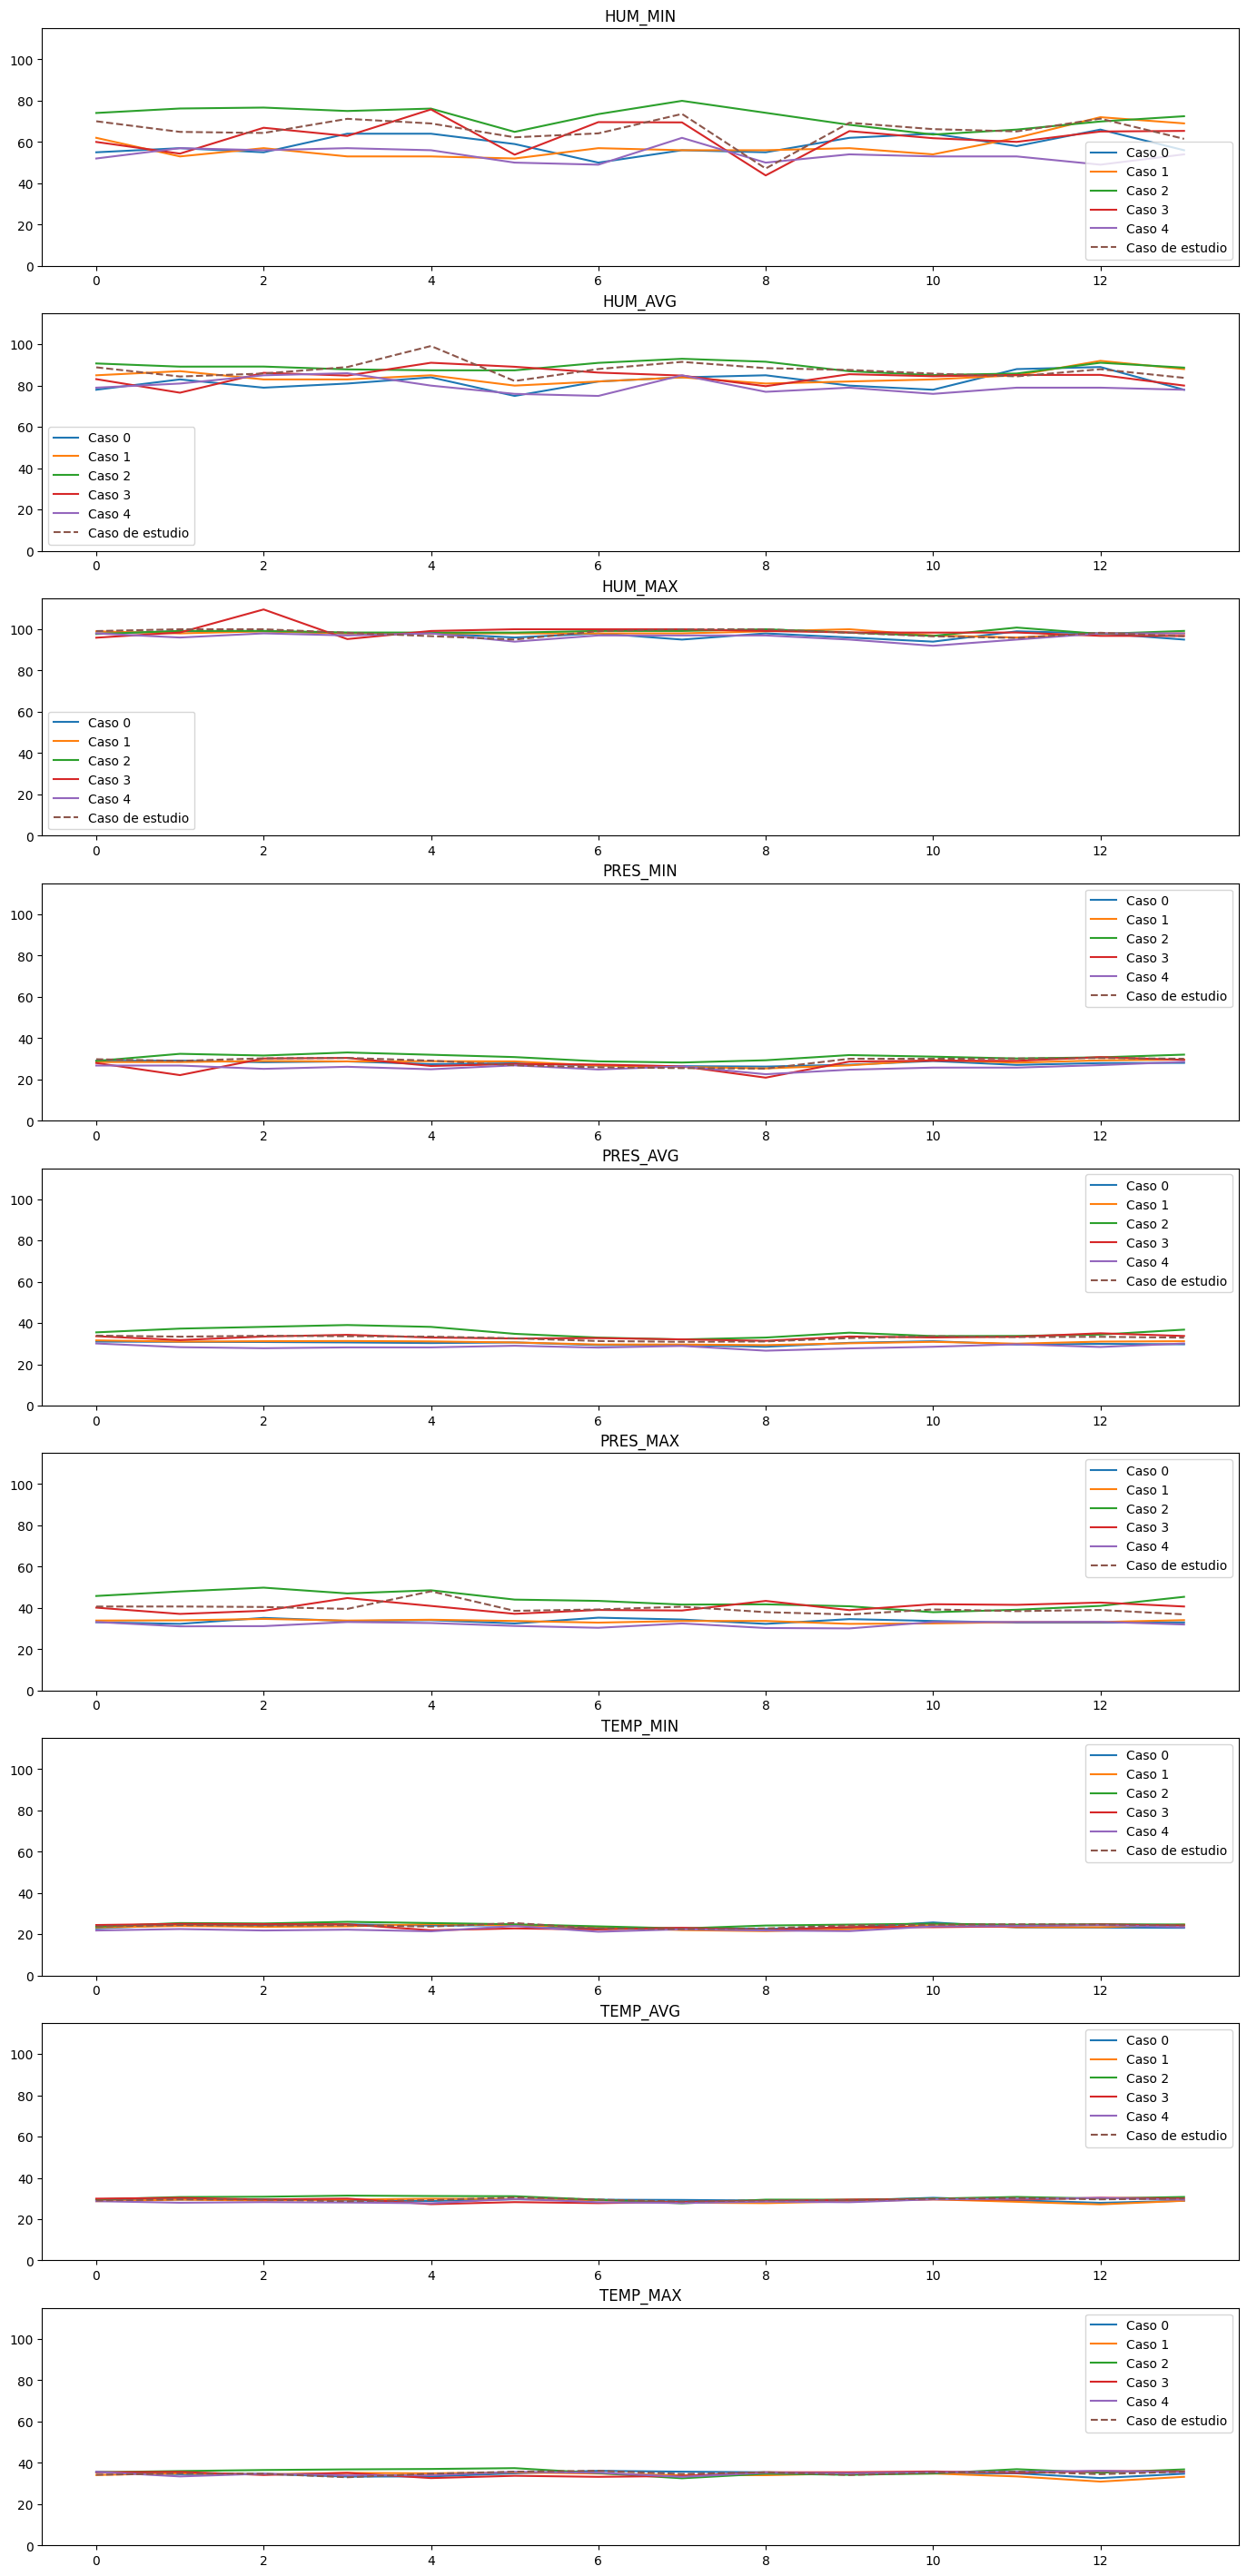

In [17]:
cbrFoxInstancia.visualizeBestCases(figsize= (17, 4*9))

### Visualización de las ventanas menos parecidas a la ventana de estudio de acuerdo a cada componente

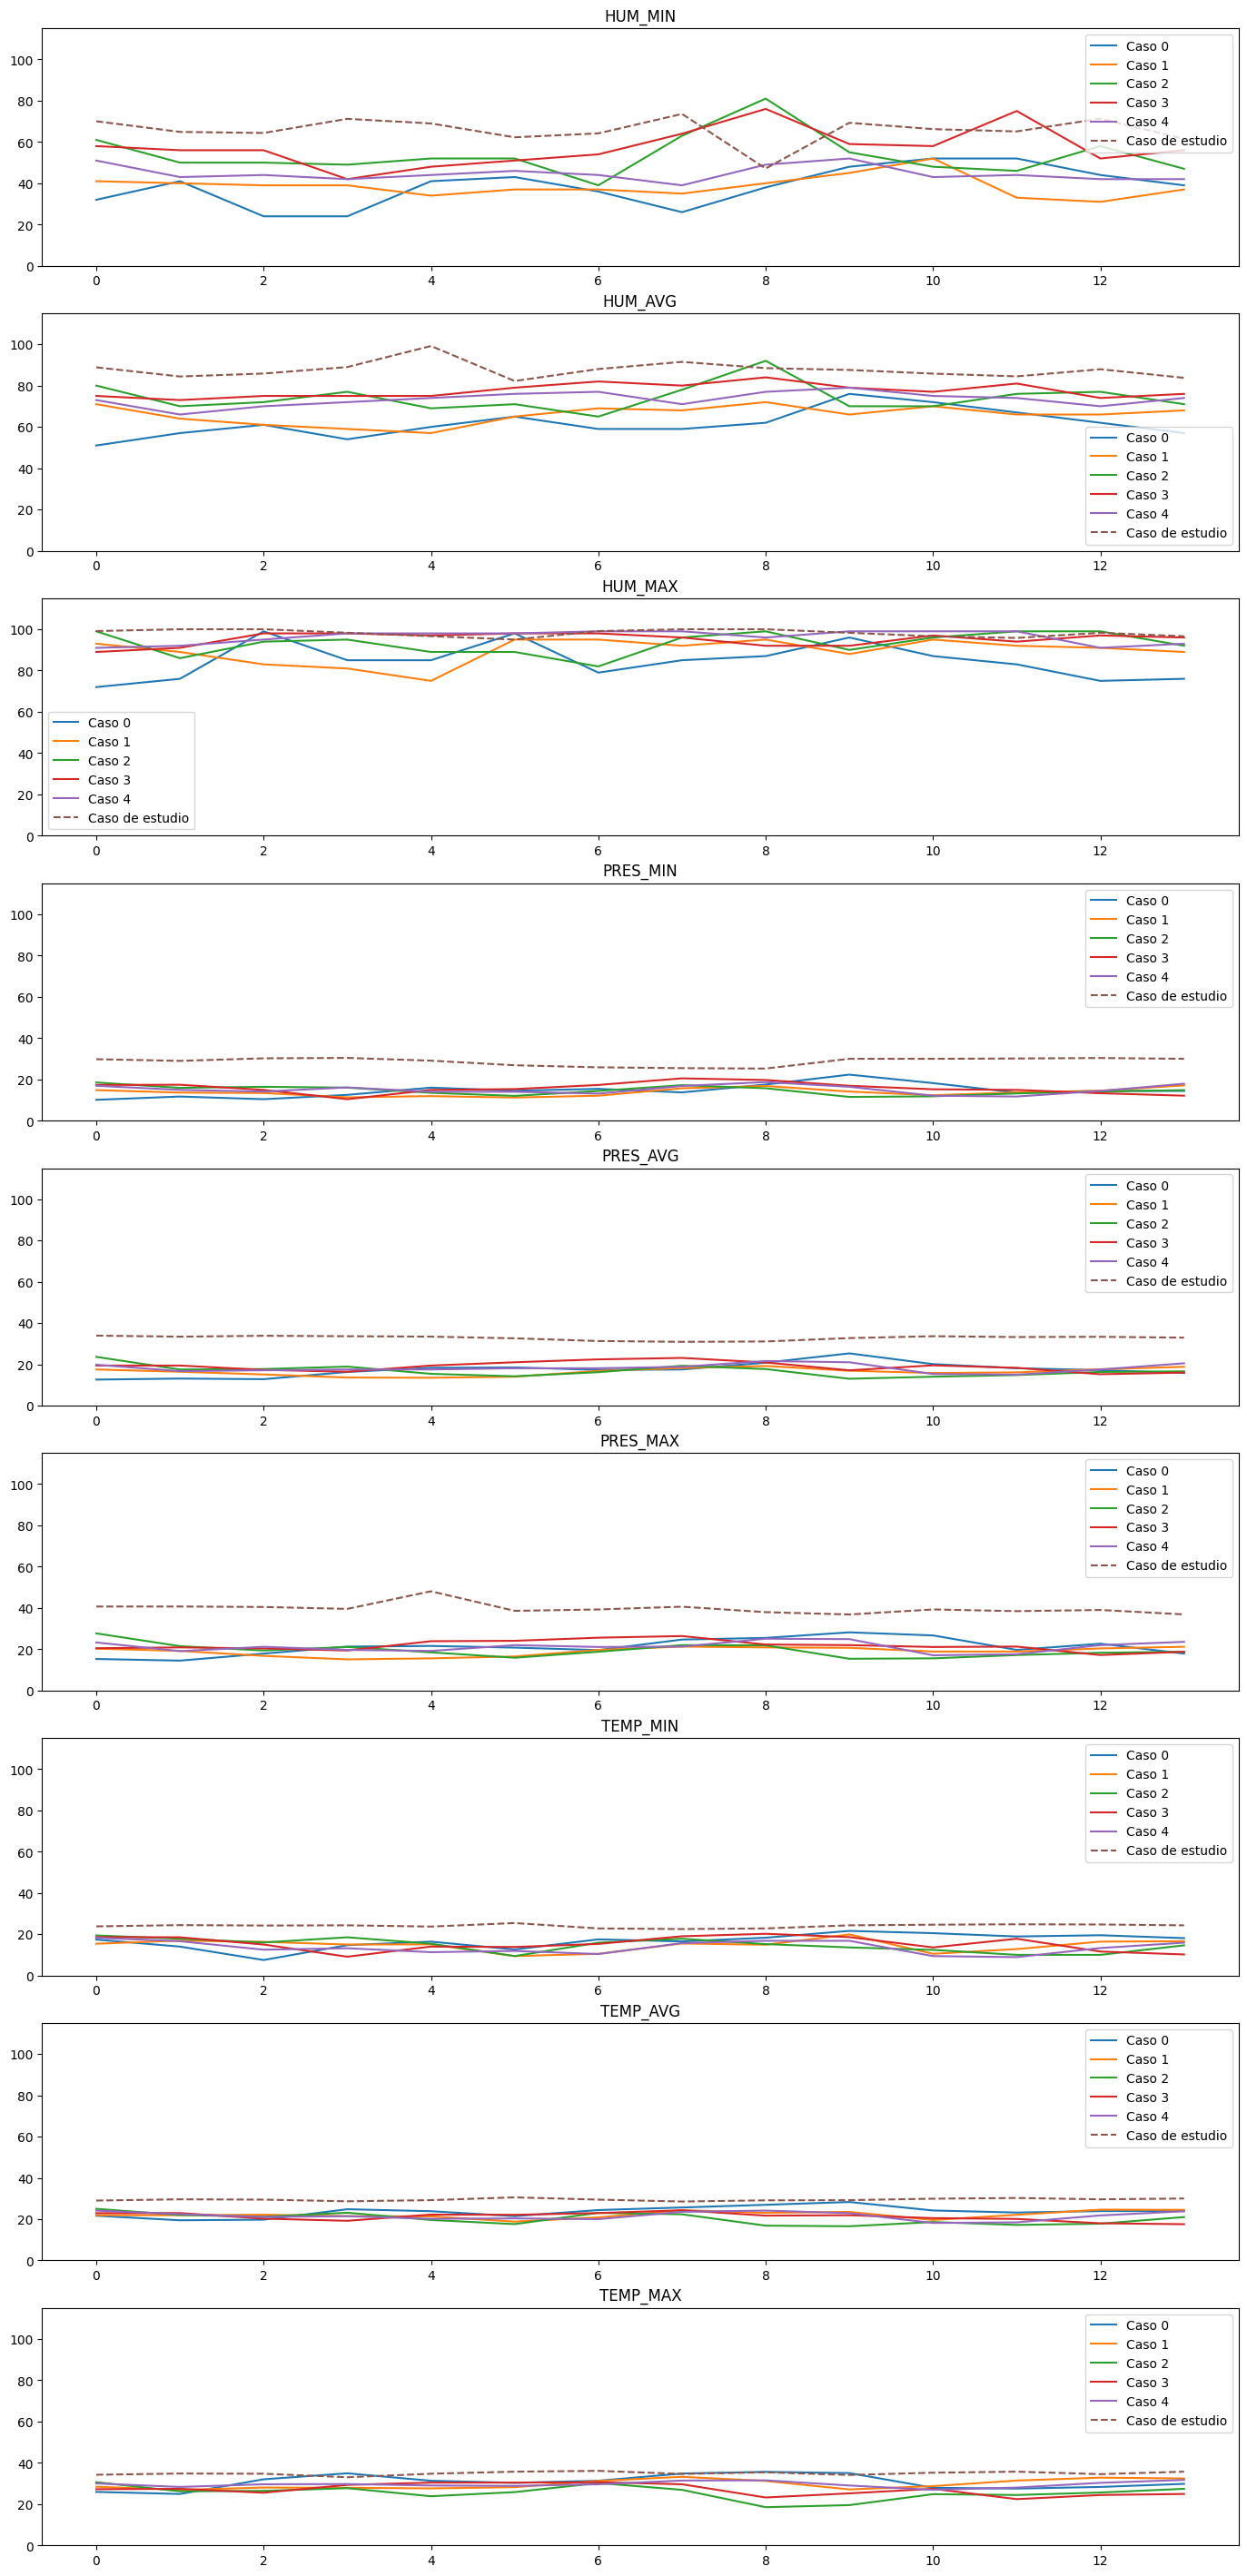

In [18]:
cbrFoxInstancia.visualizeWorstCases(figsize= (17, 4*9))

### Visualización de las predicciones de las ventanas más parecidas a la ventana de estudio de acuerdo a cada componente. Incluyendo la predicción del caso de estudio

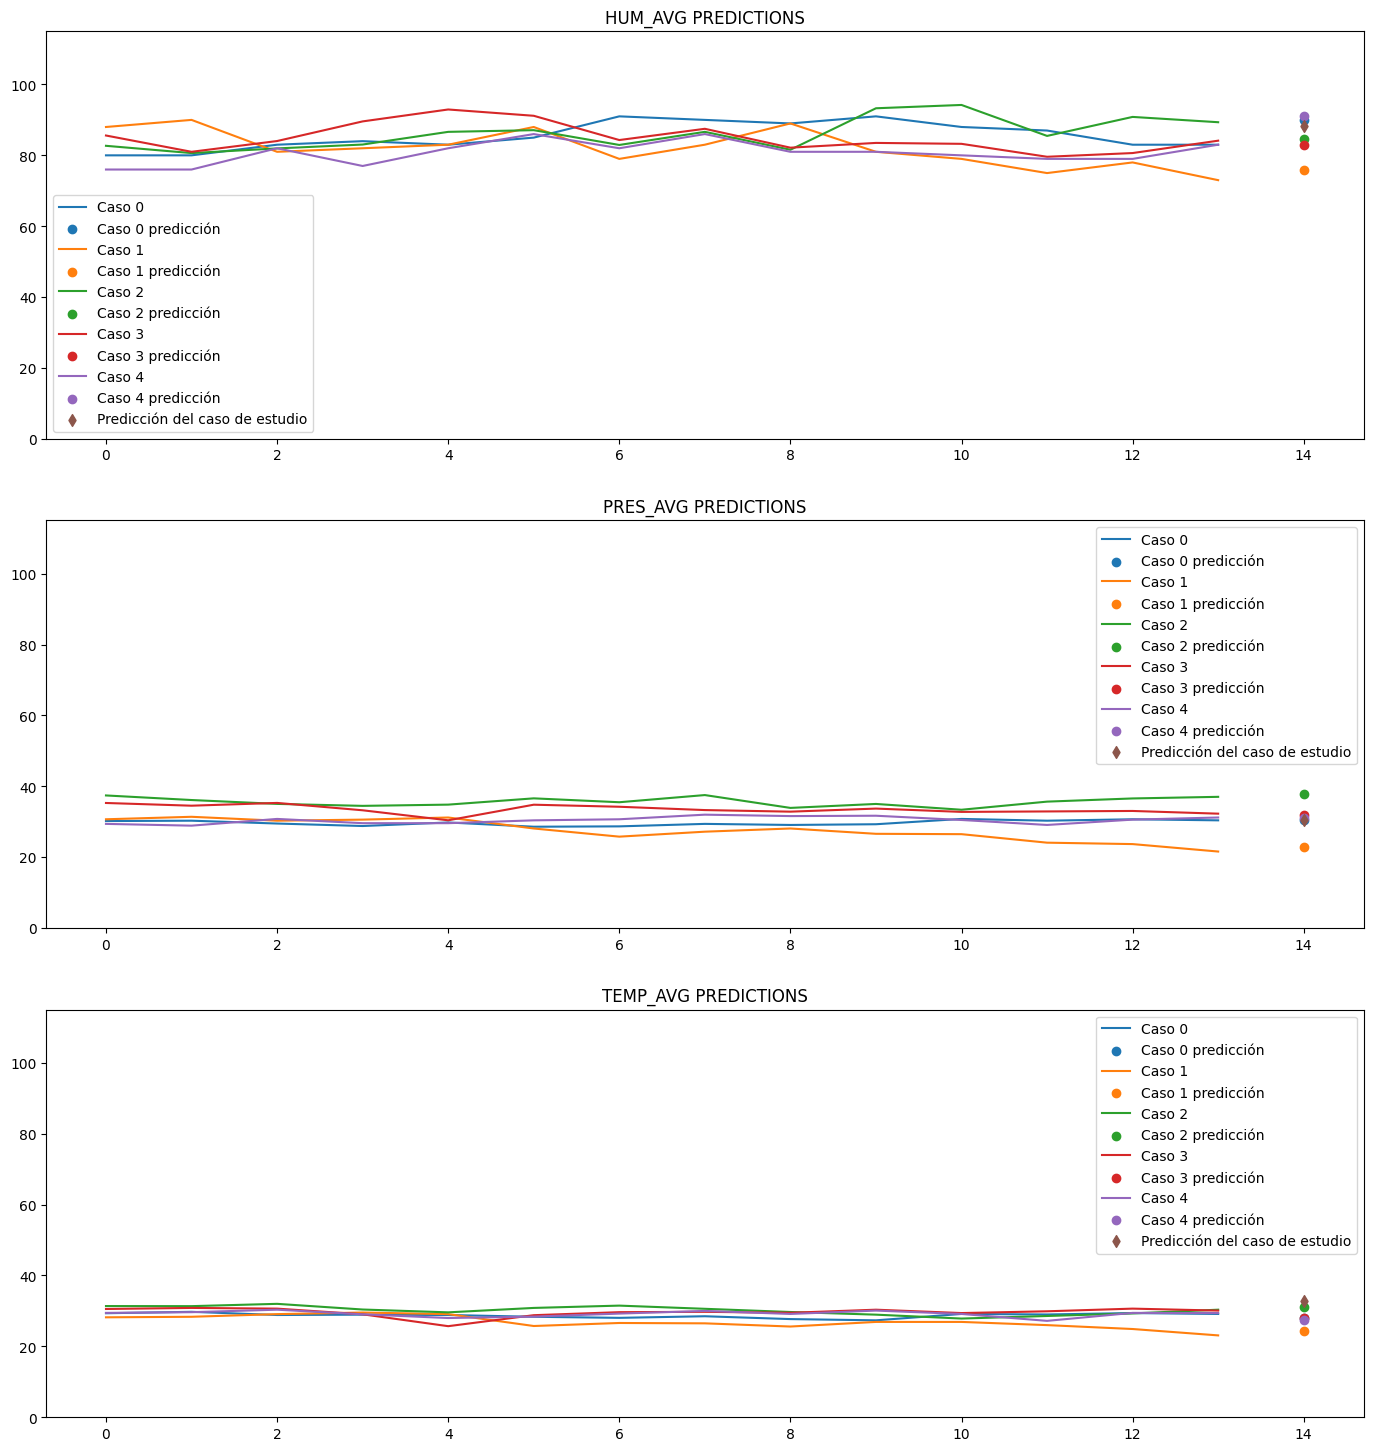

In [19]:
cbrFoxInstancia.visualizeBestHistoryPredictions(figsize= (17, 6*3))

### Visualización de las predicciones de las ventanas menos parecidas a la ventana de estudio de acuerdo a cada componente. Incluyendo la predicción del caso de estudio

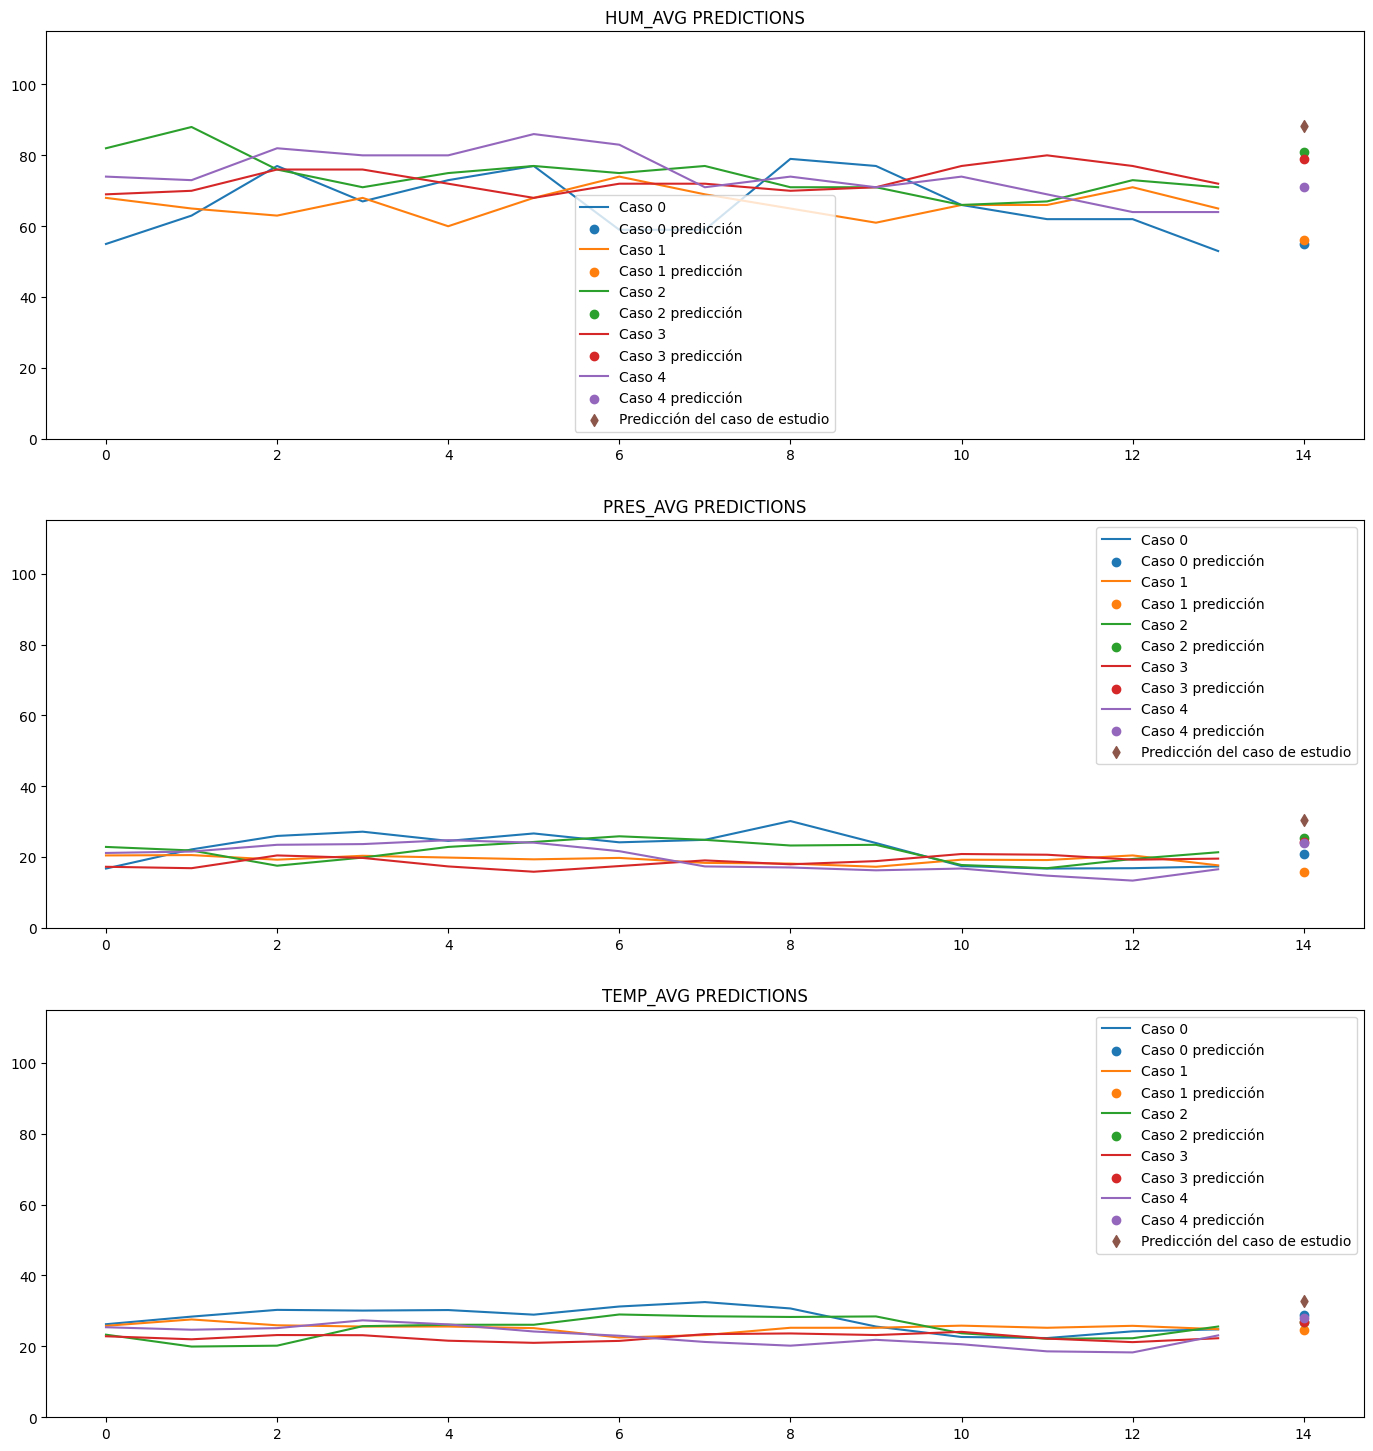

In [20]:
cbrFoxInstancia.visualizeWorstHistoryPredictions(figsize= (17, 6*3))

### Visualización de las predicciones de cada componente de las ventanas más parecidas

4.0282641092936196
1.7533836364746094
4.706004526474611
3.3036900131412743
5.594930775960287


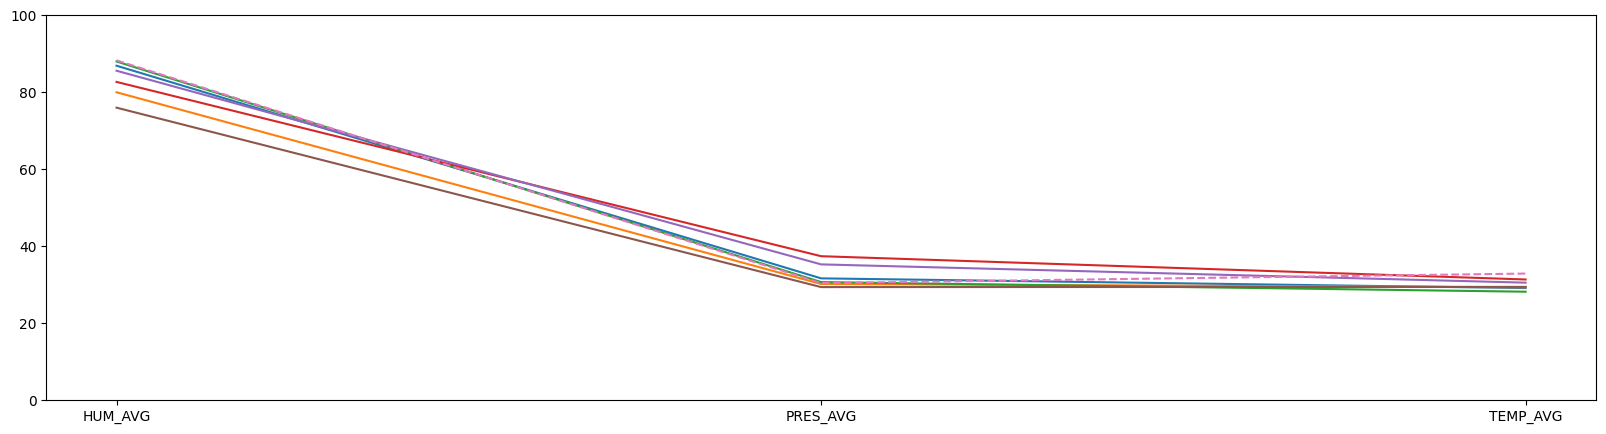

In [21]:
cbrFoxInstancia.visualizeBestCasePredictions()

### Visualización de las predicciones de cada componente de las ventanas menos parecidas

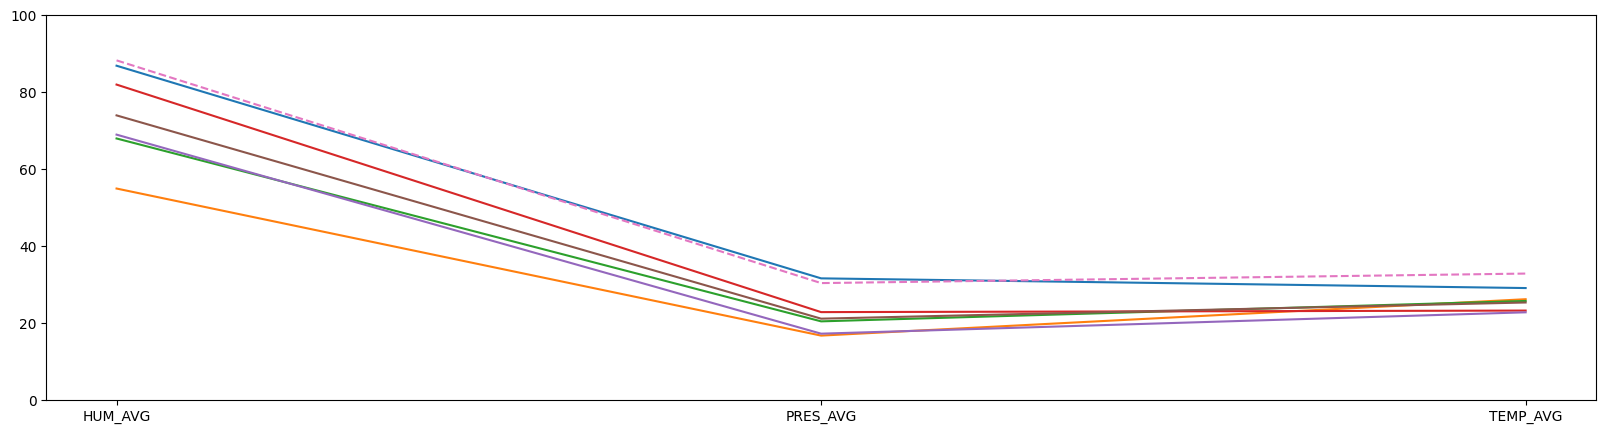

In [22]:
cbrFoxInstancia.visualizeWorstCasePredictions()

### Visualización de un objeto Dataframe que retiene los resultados de la métrica MAE de las últimas dos gráficas

In [26]:
cbrFoxInstancia.getAnalysisreport()

,index,CCI,MAE,index.1,CCI.1,MAE.1
0,4972,1.000000,4.028264,4809,0.410155,17.861597
1,263,0.979834,1.753384,1841,0.423713,12.444931
2,6062,0.975253,4.706005,3653,0.437751,7.811597
3,6410,0.967463,3.303690,1101,0.440702,14.161597
4,2072,0.960770,5.594931,14,0.447507,10.344931
